In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import math
from PIL import Image

%matplotlib inline


In [6]:
## MODEL PARAMETERS

# Cell
mu = 0.9/3600        # max growth rate of strain 1 (in 1/sec)
Qhf = 30           # cell density for half pressure (in g/mL dcw)
Phf = 20           # cell density for half acceptance (in g/mL dcw)
Y = 200               # biomass yield (in g biomass/g glucose)

# Glucose
Ks = 4*10**-3         # rate of nutrient consumption by Monod kinetics (in g/mL)

# Diffusion
u = 1                 # friction parameter for cell diffusion
v = 1                 # pressure parameter for cell diffusion
Cpack = 1
rho = 0             # cell packing efficiency
DC = 1700              # spreading coefficient of cells (in um^2)
DS = 200              # diffusion coefficient of glucose (in um^2/sec)

# Initial condition
k = 4             # coffee-ring effect factor
R = 3              # spot radius in mm
dR = 0.01            # thickness of coffee ring in mm
S0 = 0.4            # glucose concentration in feed medium (in g/mL)
f = 1.3              # initial density of loading sites for C1 (fraction of mesh points)
C0 = 6             # inital biomass density at loading sites (dimensionless)

In [7]:
# Frame width (x and y axis - assuming square frame) in um
Len = 15000
# Space desolution in um
dx = 37.5
# Time Resolution in sec
dt = 1
# Time steps
T = 90000
# Number of divisions in space
Lx = int(Len/dx)

res = dt/dx**2 

print("Frame dimensions are", Len, "X", Len, "micrometer sq. \n dx = ", dx, "micrometers")
print("Simulation time is", dt*T, "seconds \n dt =", dt, "seconds")
print("dt / dx^2 = ", res)

Frame dimensions are 15000 X 15000 micrometer sq. 
 dx =  37.5 micrometers
Simulation time is 90000 seconds 
 dt = 1 seconds
dt / dx^2 =  0.0007111111111111111


In [33]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [34]:
def initialize_2d(C0, S0):
    
    '''Sampling a fraction of mesh points uniformly randomly and loading each with a fixed cell density'''
    
    C = np.zeros((Lx+1,Lx+1))
    S = np.ones((Lx+1,Lx+1))*S0
    
    # sample random points to load bacteria
    ind = np.random.randint(low=1, high=int((Lx-1)*(Lx-1)), size=int(np.ceil(f*(Lx-1)*(Lx-1))))

    for i in ind:
        x = int(np.ceil(i/(Lx-1)))
        y = i%(Lx-1)+1
        C[x,y] = C0
    
    # mask a circular region in the middle to load cells. Clear cells everywhere else
    h, w = C.shape[:2]
    mask1 = create_circular_mask(h, w, radius=int(R*1000/dx))
    C[~mask1] = 0
    mask2 = create_circular_mask(h, w, radius=int((R-dR)*1000/dx))
    C[~mask2] *= k
        
    return(C, S)

In [35]:
def nbr_sum(M):
    """Get the discrete Laplacian of matrix M"""
    L = np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += nbr_sum(M)
    
    return L

def divide(M1,M2):
    """To divide two numpy arrays M1/M2 element-wise and avoide division by zero"""
    f = np.divide(M1, M2, out=np.zeros_like(M1), where=M2!=0)
    return f

def D(M, Cpack, rho):
    '''Density dependent diffusion function for external molecules'''
    f = (Cpack-rho*M)/(Cpack+rho*M/2)
    return f

def den_dep_diffusion_mol(S, M, rho):
    '''finite difference approximation of the diffusion term for S'''
    
    S_r = np.roll(S, (0,-1), (0,1)) # right neighbor
    S_l = np.roll(S, (0,+1), (0,1)) # left neighbor
    S_t = np.roll(S, (-1,0), (0,1)) # top neighbor
    S_b = np.roll(S, (+1,0), (0,1)) # bottom neighbor
    
    M_r = np.roll(M, (0,-1), (0,1)) # right neighbor
    M_l = np.roll(M, (0,+1), (0,1)) # left neighbor
    M_t = np.roll(M, (-1,0), (0,1)) # top neighbor
    M_b = np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    Dif = (D(M_r, Cpack, rho) + D(M_t, Cpack, rho) - D(M_b, Cpack, rho) - D(M_l, Cpack, rho))*(S_r+S_t-S_b-S_l)/4 \
        + D(M, Cpack, rho)*discrete_laplacian(S)
    
    return Dif

def q(C, Qhf):
    Q = C**v/(Qhf**v+C**v)
    #Q = C**v
    #Q[Q>1]=1
    return Q

def p(M, Phf):
    P = Phf**u/(Phf**u+C**u)
    #P = 1-Q(C,Phf)
    return P

In [24]:
def update(C, S, Qhf, Phf):
    
    Q = q(C, Qhf)
    P = p(C, Phf)
    
    #Sdiff = res*DS*den_dep_diffusion_mol(S, C, rho) - dt*mu*C*divide(S,Y*(Ks+S))
    Sdiff = res*DS*discrete_laplacian(S) - dt*mu*C*divide(S,Y*(Ks+S))
    Cdiff = dt*mu*C*(1-Q)*S/(Ks+S) + res*DC*mu*(P*nbr_sum(Q*C*S/(Ks+S)) - Q*C*S*nbr_sum(P)/(Ks+S))
    
    if math.isnan(np.max(Cdiff)):
        plt.imshow(Cdiff)
    
    C += Cdiff
    S += Sdiff
    # Remove negative values
    C[C < 0] = 0
    S[S < 0] = 0 
    
    # Reflecting boundaries
    
    C[0,:], S[0,:] = C[1,:], S[1,:]          # top
    C[-1,:], S[-1,:] = C[-2,:], S[-2,:] # bottom
    C[:,0], S[:,0] = C[:,1], S[:,1]         # left
    C[:,-1], S[:,-1] = C[:,-2], S[:,-2]  # right
                            
    return C, S

In [15]:
# Simulate

update_every = 500 # number of time steps after which data is stored
C_time = []
S_time = []
C, S = initialize_2d(C0, S0)

Text(0, 0.5, 'Cell density')

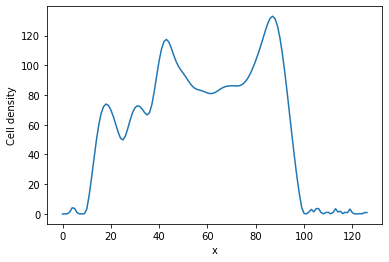

In [45]:
plt.plot(C[:,50])
plt.xlabel('x')
plt.ylabel('Cell density')

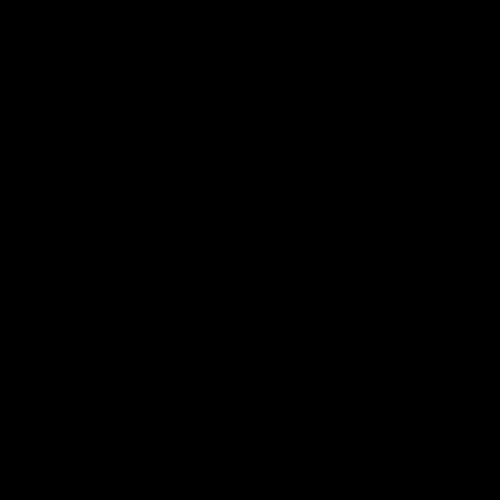

In [50]:
# Create image of final density distribution for C1 (Red) and C2 (Blue)

brightness = 1 # factor to multiply brightness

rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
C[C<0] = 0
rgb[..., 0] = C*256*brightness
rgb[..., 0][rgb[..., 0]>255] = 255
img = Image.fromarray(rgb)
img.resize((500,500), Image.ANTIALIAS)

In [283]:
######## TEST ###############

start = time.time()

for tt in range(T):
    if tt%update_every == 0:
        C_time.append(C.copy())
        S_time.append(S.copy())
        
    Q = q(C, Qhf)
    P = p(C, Phf)
    
    #Sdiff = res*DS*den_dep_diffusion_mol(S, C, rho) - dt*mu*C*divide(S,Y*(Ks+S))
    Sdiff = res*DS*discrete_laplacian(S) - dt*mu*C*divide(S,Y*(Ks+S))
    Cdiff = dt*mu*C*P*S/(Ks+S) + res*DC*mu*(P*nbr_sum(Q*C*S/(Ks+S)) - Q*C*S*nbr_sum(P)/(Ks+S))
    
    if math.isnan(np.max(Cdiff)):
        break
    
    C += Cdiff
    S += Sdiff
    # Remove negative values
    C[C < 0] = 0
    S[S < 0] = 0 
    
    # Reflecting boundaries
    
    C[0,:], S[0,:] = C[1,:], S[1,:]          # top
    C[-1,:], S[-1,:] = C[-2,:], S[-2,:]     # bottom
    C[:,0], S[:,0] = C[:,1], S[:,1]         # left
    C[:,-1], S[:,-1] = C[:,-2], S[:,-2]      # right

stop = time.time()

print("end of simultaion. Time taken = {} seconds".format(stop-start))

end of simultaion. Time taken = 77.01437783241272 seconds


In [29]:
update_every = 500
start = time.time()
C_time = []
S_time = []

for tt in range(T):
    if tt%update_every == 0:
        C_time.append(C.copy())
        S_time.append(S.copy())
    C, S = update(C, S, Qhf, Phf)

stop = time.time()

print("end of simultaion. Time taken = {} seconds".format(stop-start))

end of simultaion. Time taken = 71.82635116577148 seconds


No handles with labels found to put in legend.


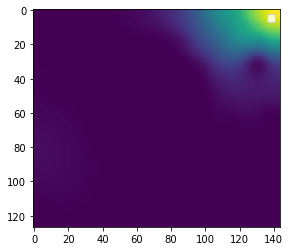

In [43]:
plt.imshow(S_time[-1])
plt.legend()

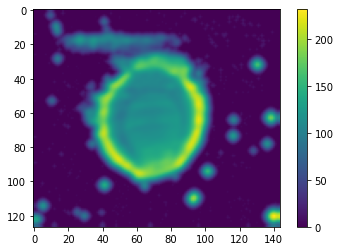

In [30]:
plt.imshow(C)
plt.colorbar()


In [27]:
plt.imshow(divide(Cdiff,C), label='u=0.25, v=4')
plt.legend()


NameError: name 'Cdiff' is not defined

In [ ]:
plt.plot(S_time[-1][:,50])

In [46]:
# Create image of final density distribution for C1 (Red) 

brightness = 1 # factor to multiply brightness

C_time = C_time/np.max(C_time)
rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
C_time[-1][C_time[-1]<0] = 0
rgb[..., 0] = C_time[-1]*255*brightness
rgb[..., 0][rgb[..., 0]>255] = 255
img = Image.fromarray(rgb)
img.resize((500,500), Image.ANTIALIAS)

ValueError: could not broadcast input array from shape (127,144) into shape (401,401)

In [ ]:
# Create GIF
brightness = 1 # factor to multiply brightness

images=[]
C_time = C_time/np.max(C_time)
for i in range(len(C_time)):
    rgb = np.zeros((len(imf_r),len(imf_r[0]),3), 'uint8')
    C_time[i][C_time[i]<0] = 0
    rgb[..., 0] = (C_time[i])*255*brightness
    rgb[..., 0][rgb[..., 0]>255] = 255
    img = Image.fromarray(rgb)
    images.append(img.resize((500,500), Image.ANTIALIAS))

images[0].save('test.gif', format='GIF', append_images=images[1:], save_all=True, duration=1, loop=0)

end of simultaion. Time taken = 76.36809921264648 seconds
end of simultaion. Time taken = 75.77538776397705 seconds
end of simultaion. Time taken = 75.93782114982605 seconds


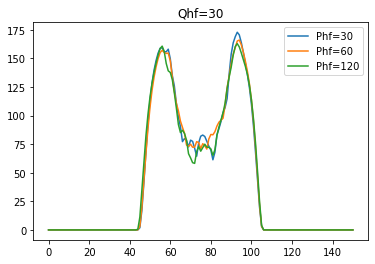

In [36]:
Q_vals = [30]
P_vals = [30, 60, 120]
v_vals= [1]

for Qhf in Q_vals:
    for Phf in P_vals:
        for v in v_vals:
            
            update_every = 500 # number of time steps after which data is stored
            C_time = []
            S_time = []
            C, S = initialize_2d(C0, S0)
            
            start = time.time()

            for tt in range(T):
                if tt%update_every == 0:
                    C_time.append(C.copy())
                    S_time.append(S.copy())
                C, S = update(C, S, Qhf, Phf)

            stop = time.time()

            print("end of simultaion. Time taken = {} seconds".format(stop-start))
            

            plt.plot(C_time[-1][:,50], label='Phf={}'.format(Phf))

plt.title('Qhf={}'.format(Q_vals[0]))
plt.legend()

In [148]:
type(np.inf)

float

In [15]:
imf = np.array(Image.open('monocultures_AY41_AY43_25oct2022-01_s2t01_CFP.jpg').convert('L'))

In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

def div0( a, b, fill=0 ):
    """ a / b, divide by 0 -> `fill`
        div0( [-1, 0, 1], 0, fill=np.nan) -> [nan nan nan]
        div0( 1, 0, fill=np.inf ) -> inf
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
    if np.isscalar( c ):
        return c if np.isfinite( c ) \
            else fill
    else:
        c[ ~ np.isfinite( c )] = fill
        return c
    
def resolve_down(im, factor1, factor2):
    new = []
    for a in im:
        b = a.reshape(-1, factor1).mean(axis=1)
        new.append(b)
    new = np.array(new).T
    neww = []
    for a in new:
        b = a.reshape(-1, factor2).mean(axis=1)
        neww.append(b)
    newww = np.array(neww).T
    
    return newww

def q(C, Qhf):
    Q = C/(Qhf+C)
    #Q = C**v
    #Q[Q>1]=1
    return Q

def p(C, Phf):
    P = Phf/(Phf+C)
    #P = 1-Q(C,Phf)
    return P

In [19]:
print(len(imf),len(imf[0]))
factor1 = 44
factor2 = 40

imf_r = resolve_down(imf,factor1, factor2)

5080 6336


In [20]:
imf_r-=2
imf_r[imf_r<0]=0

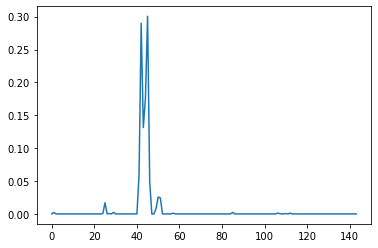

In [21]:
plt.plot(imf_r[14])

In [22]:
S = np.ones((len(imf_r),len(imf_r[0])))*S0
C = imf_r

In [25]:
update_every = 500
start = time.time()
C_time = []
S_time = []

for tt in range(T):
    if tt%update_every == 0:
        C_time.append(C.copy())
        S_time.append(S.copy())
    C, S = update(C, S, Qhf, Phf)

stop = time.time()

print("end of simultaion. Time taken = {} seconds".format(stop-start))

NameError: name 'discrete_laplacian' is not defined

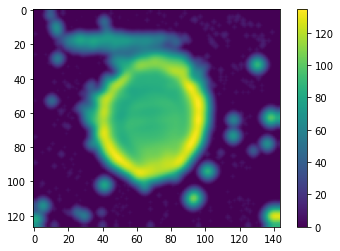

In [44]:
plt.imshow(C)
plt.colorbar()